In [1]:
import os
import pg8000
import sqlalchemy
import pandas as pd
from operator import add
from typing import Literal
from sqlalchemy import text
from typing import Annotated
from pydantic import BaseModel
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain.schema import Document
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langchain_community.vectorstores import FAISS
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate
from langchain.document_loaders import DataFrameLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.output_parsers import StrOutputParser
from google.cloud.sql.connector import Connector, IPTypes
from langchain_core.vectorstores.base import VectorStoreRetriever

In [2]:
%pwd

'/Users/henil08/College/Semesters/Fall 2024/eCom-Chatbot/notebooks'

In [3]:
os.chdir('../')

In [4]:
load_dotenv()

True

In [5]:
## load the API Keys
os.environ['HF_TOKEN']=os.getenv("HF_TOKEN")
os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")

## Langfuse
os.environ['LANGFUSE_PUBLIC_KEY']=os.getenv("LANGFUSE_PUBLIC_KEY")
os.environ['LANGFUSE_SECRET_KEY']=os.getenv("LANGFUSE_SECRET_KEY")
os.environ['LANGFUSE_HOST']=os.getenv("LANGFUSE_HOST")

## Postgres DB
instance_connection_name = os.getenv("INSTANCE_CONNECTION_NAME")
db_user = os.getenv("DB_USER")  
db_pass = os.getenv("DB_PASS")  
db_name = os.getenv("DB_NAME")  

In [6]:
from langfuse.callback import CallbackHandler

langfuse_handler = CallbackHandler(
    public_key=os.environ['LANGFUSE_PUBLIC_KEY'],
    secret_key=os.environ['LANGFUSE_SECRET_KEY'],
    host=os.environ['LANGFUSE_HOST']
)

In [7]:
REVIEW_TABLE = "ecom-chat-437005.ecom_chat.review"
META_TABLE = "ecom-chat-437005.ecom_chat.meta"
PARENT_ASIN = 'B07MQFWF1B'

## Connect Postgres

In [8]:
def connect_with_db() -> sqlalchemy.engine.base.Engine:
    ip_type = IPTypes.PRIVATE if os.getenv("PRIVATE_IP") else IPTypes.PUBLIC
    connector = Connector()
    def getconn() -> pg8000.dbapi.Connection:
        conn: pg8000.dbapi.Connection = connector.connect(
            instance_connection_name,
            "pg8000",
            user=db_user,
            password=db_pass,
            db=db_name,
            ip_type=ip_type,
        )
        return conn
    pool = sqlalchemy.create_engine(
        "postgresql+pg8000://",
        creator=getconn,
    )
    return pool

In [9]:
engine = connect_with_db()

In [10]:
with engine.begin() as connection:
    try:
        query = text(f"""
                     SELECT parent_asin, asin, helpful_vote, timestamp, verified_purchase, title, text
                     FROM userreviews ur 
                     WHERE ur.parent_asin = '{PARENT_ASIN}';""")
        result = connection.execute(query)
        review_df = pd.DataFrame(result.fetchall(), columns=result.keys())
    except Exception as e: print(e)

In [11]:
review_df.head()

,parent_asin,asin,helpful_vote,timestamp,verified_purchase,title,text
0,B07MQFWF1B,B07MQFWF1B,0,2019-10-30 18:35:35.344,True,Girl like it,"Girl love it , she can paint on it also"
1,B07MQFWF1B,B07MQFWF1B,0,2020-10-07 23:03:31.400,True,Nice design but needs tape to support it,This is the 4th cardboard house that I've purc...
2,B07MQFWF1B,B07MQFWF1B,0,2021-01-15 13:40:07.739,True,Great purchase for my 4 and 6 yr olds,My girls love this and I live that it is a wor...


In [12]:
with engine.begin() as connection:
    try:
        query = text(f"""
                     SELECT parent_asin, main_category, title, average_rating, rating_number, features, description, price, store, categories, details
                     FROM metadata md 
                     WHERE md.parent_asin = '{PARENT_ASIN}';
                """)
        result = connection.execute(query)
        meta_df = pd.DataFrame(result.fetchall(), columns=result.keys())
    except Exception as e: print(e)

In [13]:
meta_df.head()

,parent_asin,main_category,title,average_rating,rating_number,features,description,price,store,categories,details
0,B07MQFWF1B,Toys & Games,Easy Playhouse Valentine Cottage-Kids Art and ...,4.5,57,['PERSONALIZE YOUR FESTIVE VALENTINE COTTAGE -...,"[""Love is in the air! Your little ones will wa...",None,Easy Playhouse,"['Toys & Games', 'Preschool', 'Pre-Kindergarte...",{'Product Dimensions': '27.25 x 18.5 x 2.13 in...


## Loading the Review Data

In [14]:
# Load the Reviews
loader = DataFrameLoader(review_df) 
review_docs = loader.load()

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectordb = FAISS.from_documents(documents=review_docs, embedding=embeddings)

retriever = vectordb.as_retriever()

/Users/henil08/College/Semesters/Fall 2024/eCom-Chatbot/verta/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
review_docs[0]

Document(metadata={'parent_asin': 'B07MQFWF1B', 'asin': 'B07MQFWF1B', 'helpful_vote': '0', 'timestamp': '2019-10-30 18:35:35.344', 'verified_purchase': 'True', 'title': 'Girl like it'}, page_content='Girl love it , she can paint on it also')

## Create LangGraph Workflow

In [16]:
class MultiAgentState(TypedDict):
    question: str
    question_type: str
    answer: str 
    documents: Annotated[list[str], add]
    meta_data: pd.DataFrame
    retriever: VectorStoreRetriever
    followup_questions: list[str]

In [17]:
MEMBERS = ["Metadata", "Review-Vectorstore"]
OPTIONS = ["FINISH"] + MEMBERS
CONDITIONAL_MAP = {k: k for k in MEMBERS}
CONDITIONAL_MAP["FINISH"] = 'generate'

In [18]:
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal[*OPTIONS] 

In [19]:
def supervisor_agent(state: MultiAgentState):
    question = state["question"]
    document = state["documents"]

    system_prompt = (
        '''
        You are an efficient supervisor responsible for overseeing a conversation between the following agents: {members}. 

        If you got response from the Agent (response given below as "Generated Answer from the Agents:"), respond with 'FINISH' to move on to next step. 
        
        Based on the user's request, decide which agent should respond next. Each agent will complete a task and return their result. 
        
        There are two agents working alongside you:
            - Metadata: This agent has all metadata information about that product. 
            - Review-Vectorstore: This is a FAISS Vectorstore db containing documents related to all the user reviews for that product.
        
        If you got unsatisfied response from the Agents (Agent Throwing Errors like: "Metadata: Unable to generate result") ONLY THEN Call an Agent a **MAXIMUM of TWO TIMES** before responding with 'FINISH'.
        Once sufficient information is obtained from the Agents, respond with 'FINISH', after which Alpha, the final assistant, will provide the concluding guidance to the user.
        If the query is generic (Hello, How are you, etc) then route it to Alpha and respond with 'FINISH.' 

        If you got satisfactory response from the Agent (response given above), respond with 'FINISH' to move on to next step. 
        '''
    )

    llm = ChatOpenAI(model_name="gpt-4o-mini")
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{question}"),
            ('system', "Generated Answer from the Agents: {document}"),
            (
                "system",
                "Given the conversation above, who should act next?"
                "Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(OPTIONS), members=", ".join(MEMBERS))


    supervisor_chain = prompt | llm.with_structured_output(RouteQuery)
    
    update_documents = [m for m in document[-5:]] # Delete the previous documents in the memory to save context

    return {'question_type' : supervisor_chain.invoke({"question": question, 'document': document}), 'question': question, 'documents': update_documents}

In [20]:
def route_question(state):
    print("---ROUTE QUESTION---")
    source = state['question_type']
    if source.datasource == "Metadata":
        print("---ROUTE QUESTION TO METADATA---")
        return "Metadata"
    elif source.datasource == "Review-Vectorstore":
        print("---ROUTE QUESTION TO FAISS---")
        return "Review-Vectorstore"
    elif source.datasource == "FINISH":
        print("---ROUTE QUESTION TO ALPHA---")
        return "FINISH"

In [21]:
def metadata_node(state: MultiAgentState):
    meta_llm = ChatGroq(model_name="llama-3.1-8b-instant")

    meta_df = state['meta_data']

    modified_details = meta_df['details'].astype(str).str.replace('{', '[')
    
    # Answer question
    meta_system_prompt =( 
        f'''
        You are a great Data Interpreter and Summarizer. Read the Product Meta Data sent to you and Produce it in 500 words.
        
        Meta Data:
        main_category: {(meta_df.at[0,'main_category'])}
        title: {(meta_df.at[0, 'title'])}
        average_rating: {(meta_df.at[0, 'average_rating'])}
        rating_number: {(meta_df.at[0, 'rating_number'])}
        features: {(meta_df.at[0, 'features'])}
        description: {(meta_df.at[0, 'description'])}
        price: {(meta_df.at[0, 'price'])}
        store: {(meta_df.at[0, 'store'])}
        categories: {(meta_df.at[0, 'categories'])}	
        details: {(modified_details.at[0])}

        Return in a proper format:
        main_category: Same 
        title: Same
        average_rating: Same
        rating_number: Same
        features: Summarize	
        description: Summarize
        price: Same
        store: Same	
        categories: Same	
        details: Same/Summarize where necessary	

        Do not answer any user question, just provide the meta data
        '''
    )

    meta_system_prompt = meta_system_prompt.replace('{', '{{').replace('}', '}}')

    meta_qa_prompt = ChatPromptTemplate.from_messages(
                    [
                        ("system", meta_system_prompt),
                    ]
                )
    parser = StrOutputParser()
    meta_chain = meta_qa_prompt | meta_llm | parser

    try:
        # Meta Summary
        meta_results = meta_chain.invoke({'input': ''})
        meta_results = Document(page_content=meta_results, metadata={"source": "Metadata"})
        
    except Exception as error:
        print(error)
        content = "Metadata: Unable to generate result"
        meta_results = Document(page_content=content, metadata={"source": "Metadata"})

    return {'documents': [meta_results], "question": state["question"]}

In [22]:
def retrieve(state: MultiAgentState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    retriever = state["retriever"]

    # Retrieval
    documents = retriever.invoke(question)

    return {"documents": documents, "question": question}

In [23]:
def final_llm_node(state: MultiAgentState):
    question = state["question"]
    documents = state["documents"]

    model = ChatGroq(model_name="llama-3.1-70b-versatile")
    system_prompt = (
        f'''
        You are Alpha, a highly knowledgeable and efficient chatbot assistant designed to help users with questions related to products.
        Your primary role is to assist users by providing concise, accurate, and insightful responses based on the product information and reviews available to you.
        If you don’t have the necessary information to answer the question, simply say that you don’t know.

        There are two agents working alongside you:
        - Metadata: This agent provides answers related to a product. It has all the information about that product.
        - Review-Vectorstore: This is a FAISS Vectorstore db containing documents related to all the user reviews for one product.
        
        When a User (Shopper) comes to you for help, the question might have first been routed through either the Metadata or the Review-Vectorstore. 

        Your primary objective is to offer clear, concise, and helpful advice to the teacher, ensuring that they receive the most accurate and useful information to support their shopping needs.

        Instructions:
        - Analyze the product information and/or reviews provided.
        - Provide brief, clear, and helpful answers to user queries about the product.
        - Focus on delivering concise and actionable insights to help users make informed decisions.

        The responses from those agents are available to you, and if their answers were incomplete or unsatisfactory, you will find this reflected in the context field. 
        Your job is to analyze their responses, determine if they are adequate, and provide additional guidance or clarification where needed.
        Below is the context from one of the agents:
        '''
        "{context}"
    )

    qa_prompt = ChatPromptTemplate.from_messages(
                    [
                        ("system", system_prompt),
                        ("human", "{input}")
                    ]
                )
    question_answer_chain = qa_prompt | model

    generation = question_answer_chain.invoke({"context": documents, "input": question})

    return {"documents": documents, "question": question, "answer": generation}

In [24]:
def followup_node(state: MultiAgentState):
    documents = state['documents']
    question = state['question']
    answer = state['answer']
    
    model = ChatGroq(model_name="llama-3.1-8b-instant")
    system_prompt = (
        '''
        Given the following:
        User Question: {question}
        Answer: {answer}
        Context: {context}
        Please generate three possible follow-up questions that the user might ask, each on a new line, without any numbering or bullet points. Do not include any explanations—just list the follow-up questions.
        Format them like this:
        question1\nquestion2\nquestion3
        '''
    )       
    follow_prompt = ChatPromptTemplate.from_messages(
                    [
                        ("system", system_prompt),
                    ]
                )
    
    followup_chain = follow_prompt | model
    followup = followup_chain.invoke({'question': question, 'answer': answer, 'context': documents[-2:]}) # just consider last two document list 
    followup_questions = followup.content.split('\n')
    
    return {"question": question, "answer": answer, "documents": documents, 'followup_questions': followup_questions}       

In [25]:
def create_graph(isMemory=True):
    memory = MemorySaver()
    builder = StateGraph(MultiAgentState)

    builder.add_node("Metadata", metadata_node)
    builder.add_node("Review-Vectorstore", retrieve)
    builder.add_node("supervisor", supervisor_agent)
    builder.add_node("generate", final_llm_node)
    builder.add_node("final", followup_node)

    for member in MEMBERS:
        builder.add_edge(member, "supervisor")

    builder.add_conditional_edges("supervisor", route_question, CONDITIONAL_MAP)

    builder.add_edge(START, "supervisor")
    builder.add_edge("generate", "final")
    builder.add_edge("final", END)

    graph = builder.compile(checkpointer=memory) if isMemory else builder.compile()

    return graph

In [26]:
app = create_graph(isMemory=False)

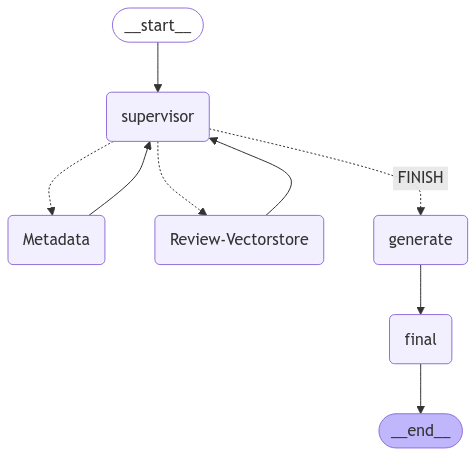

In [27]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [28]:
config = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
inputs = {"question": "What is the product dimension?", 
          "meta_data": meta_df,
          "retriever": retriever
        }
for output in app.stream(inputs, config=config):
    if 'final' in output:
        print("Question:")
        print(output['final']['question'])
        print("Answer:")
        print(output['final']['answer'].content)
        print("Followup-Questions:")
        print(output['final']['followup_questions'])

---ROUTE QUESTION---
---ROUTE QUESTION TO METADATA---
---ROUTE QUESTION---
---ROUTE QUESTION TO ALPHA---
Question:
What is the product dimension?
Answer:
The product dimension of the Easy Playhouse Valentine Cottage is 27.25 x 18.5 x 2.13 inches.
Followup-Questions:
['Is the Easy Playhouse Valentine Cottage suitable for indoor play only?', 'Can I purchase the Easy Playhouse Valentine Cottage online from Easy Playhouse directly?', 'What are the recommended age limits for the Easy Playhouse Valentine Cottage?']
